In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install "datasets>=2.5.2" "numpy>=1.24.2" "pandas>=1.4.4" "scikit-learn>=1.1.1" "torch>=1.10.2" "tqdm>=4.64.1" "transformers>=4.22.1"


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Tabula-main-claude

/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude


In [3]:
# change tabula to tabula_middle_padding to test middle padding method
from tabula import Tabula
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split


original_data = pd.read_csv("Real_Datasets/diabetes-switch-last.csv")

# train_data, test_data = train_test_split(original_data, test_size=0.1, random_state=42)

# train_data.to_csv("Real_Datasets/diabetes-train-switch.csv", index=False)
# test_data.to_csv("Real_Datasets/diabetes-test-switch.csv", index=False)

train_data = pd.read_csv("Real_Datasets/diabetes-train-switch.csv")

In [7]:
categorical_columns = ["Outcome", "Pregnancies"]
import torch

for sigma_value in [0.15]: 
    model = Tabula(
        llm='distilgpt2',
        experiment_dir="adult_training",
        batch_size=64,
        epochs=400,
        categorical_columns=categorical_columns,
        use_dp=True,
        clip_coeff=1,
        sigma=sigma_value,
        micro_batch_size=16,
        learning_rate=5e-4
    )


    model.model.load_state_dict(torch.load("pretrained-model/model.pt"), strict=False)

    model.fit(train_data)

    torch.save(model.model.state_dict(), "insurance_training/model_400epoch-lr-1e-4.pt")

    synthetic_data = model.sample(n_samples=691)
    sigma_str = f"{sigma_value:.2f}".replace('.', '')
    synthetic_data.to_csv(f"diabetes_syn_data/diabetes-switch-sigma-{sigma_str}.csv", index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

<ipython-input-7-ddd9a648baf7>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load("pretrained-model/model.pt"), strict=False)
/content/

Step,Training Loss
500,3.473900
1000,1.700900
1500,1.401900
2000,1.327600
2500,1.289000
3000,1.260600
3500,1.238000
4000,1.223100


  0%|          | 0/691 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
712it [00:20, 33.99it/s]
/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/tabula/tabula.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.label_encoder_list[i]['column']] = pd.to_numeric(data[self.label_encoder_list[i]['column']], errors='coerce')


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison_two_datasets(original_data, synthetic_data, column_names=None):
    """
    Compare the distribution of each column between original data and a single synthetic dataset.

    Parameters:
        original_data (pd.DataFrame): Original dataset.
        synthetic_data (pd.DataFrame): Synthetic dataset.
        column_names (list, optional): List of column names to compare. Defaults to all columns in original_data.
    """
    if column_names is None:
        column_names = original_data.columns

    # Iterate over each specified column
    for column in column_names:
        if column in synthetic_data.columns:
            plt.figure(figsize=(8, 4))

            # Plot original data
            sns.kdeplot(original_data[column], label='Original', color='blue', fill=True, alpha=0.3)

            # Plot synthetic data
            sns.kdeplot(synthetic_data[column], label='Synthetic', color='red', fill=True, alpha=0.3)

            # Add plot details
            plt.title(f'Distribution of {column}', fontsize=12)
            plt.legend(fontsize=10)
            plt.xlabel(column, fontsize=10)
            plt.ylabel('Density', fontsize=10)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{column}' not found in synthetic dataset.")


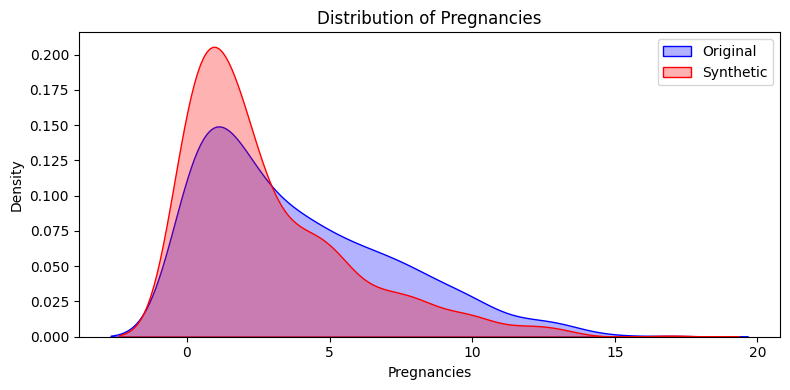

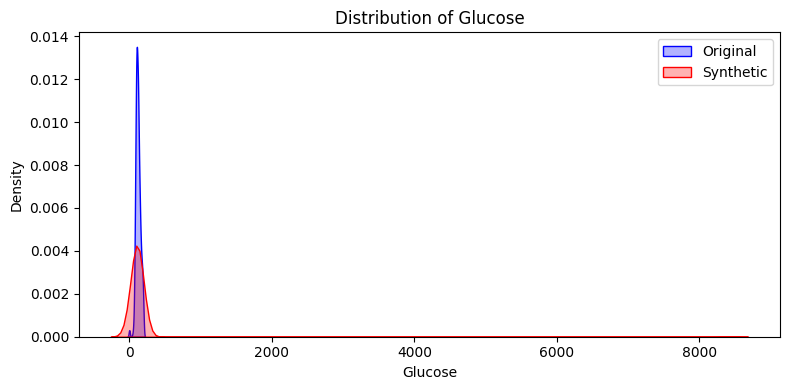

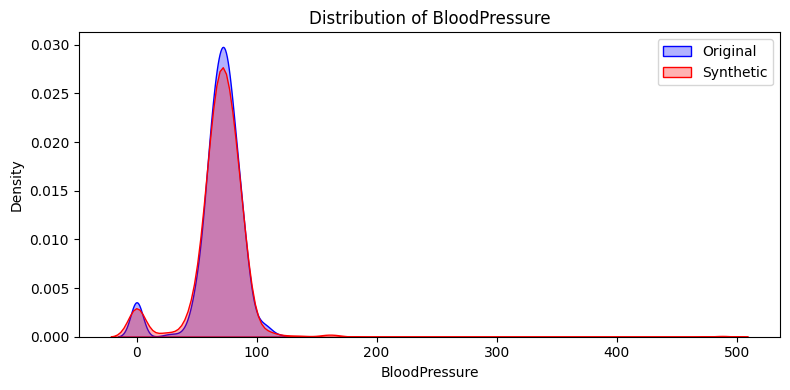

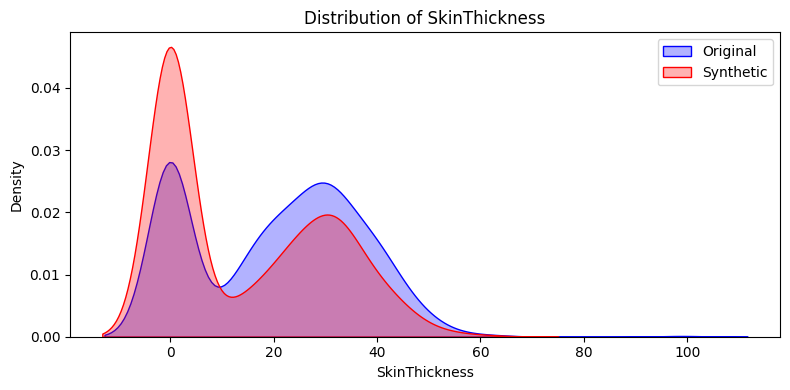

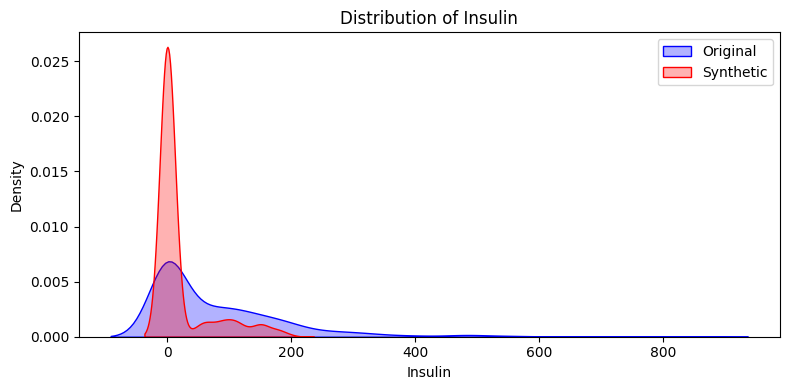

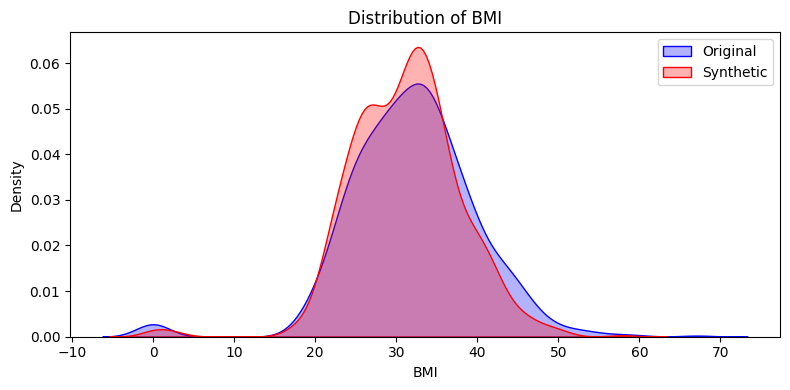

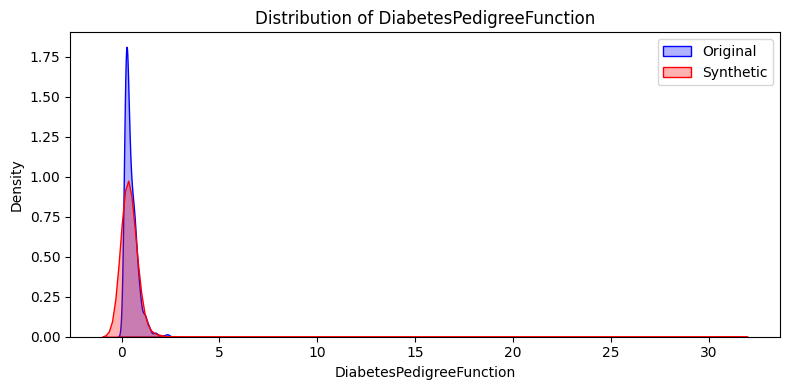

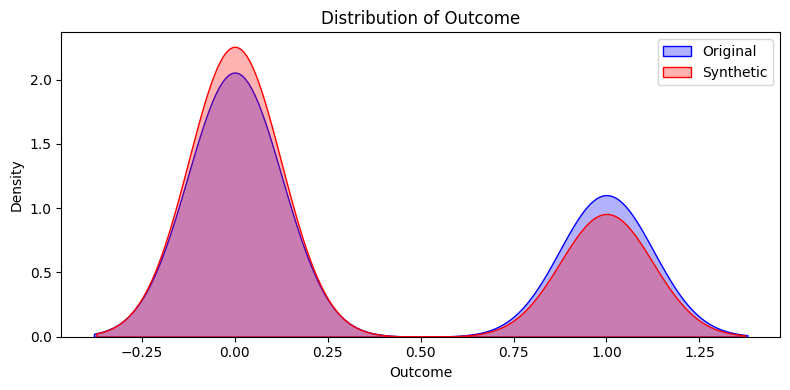

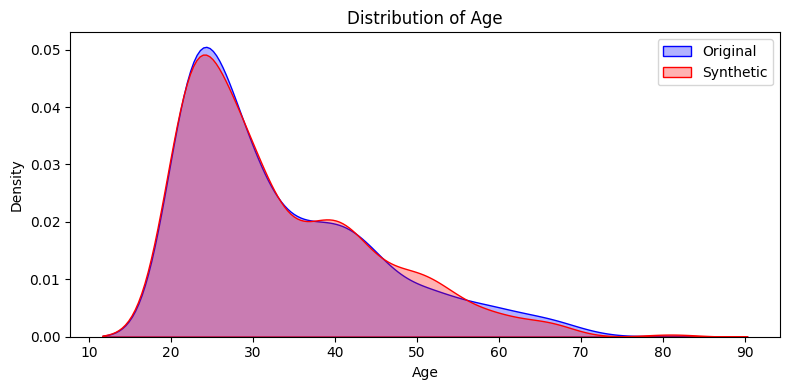

In [13]:
original_data = pd.read_csv("Real_Datasets/diabetes-switch-last.csv")
synthetic_data = pd.read_csv("diabetes_syn_data/diabetes-switch-sigma-015.csv")

plot_comparison_two_datasets(original_data, synthetic_data)

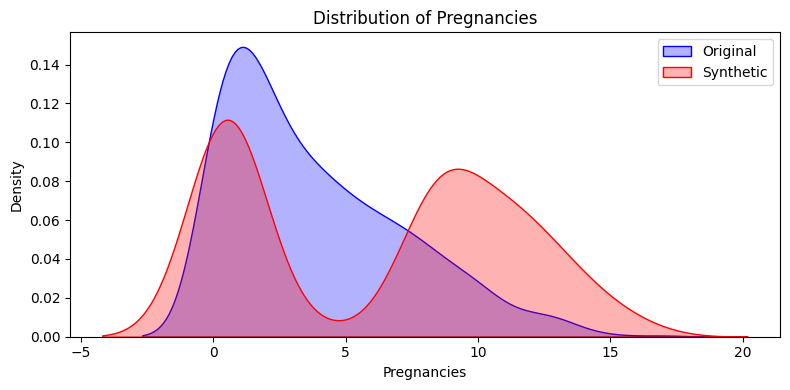

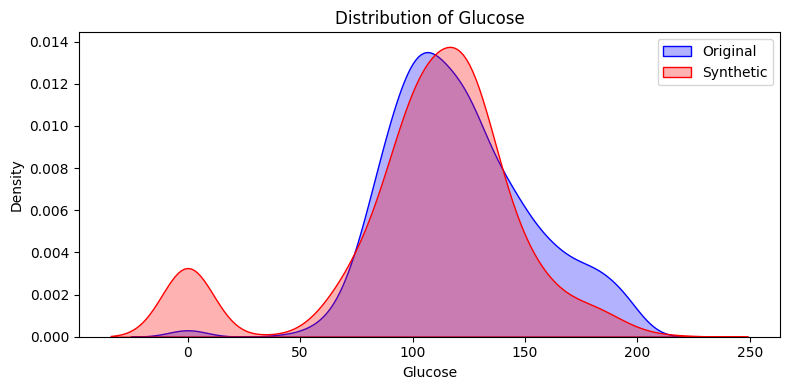

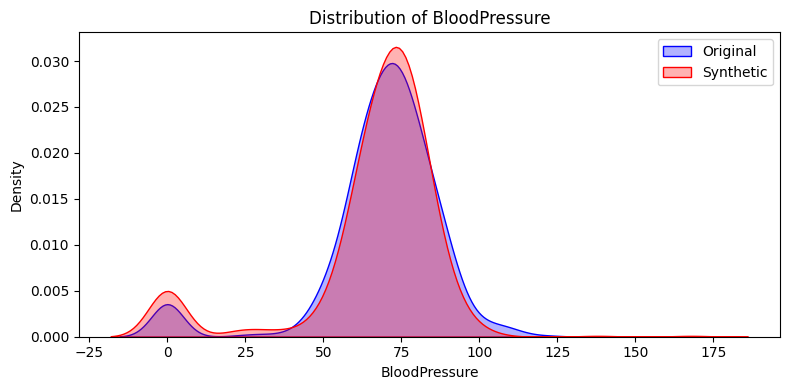

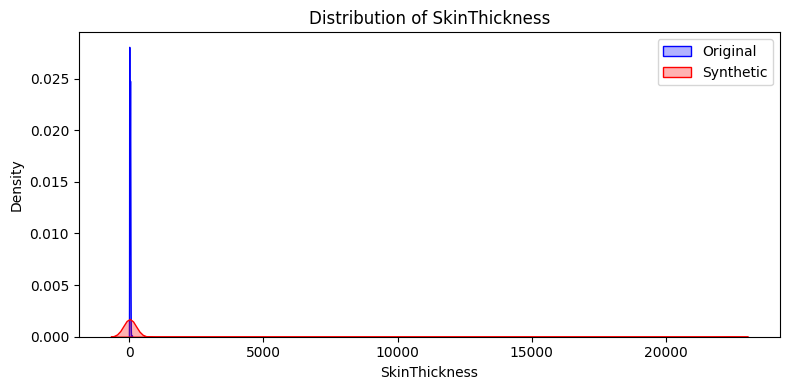

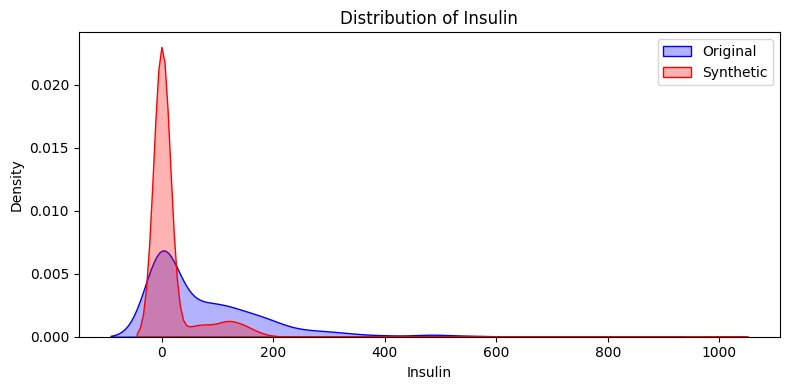

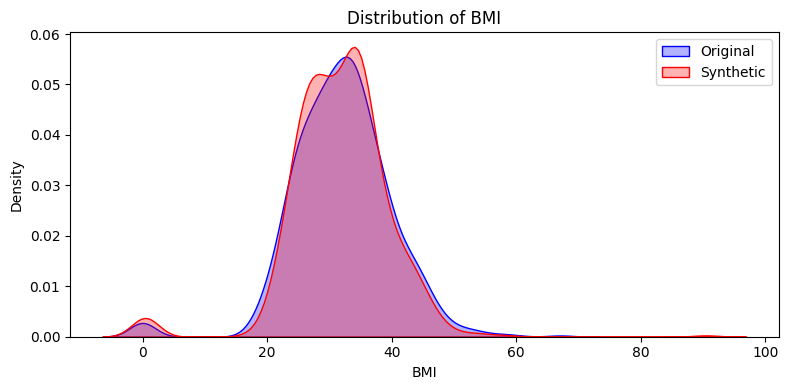

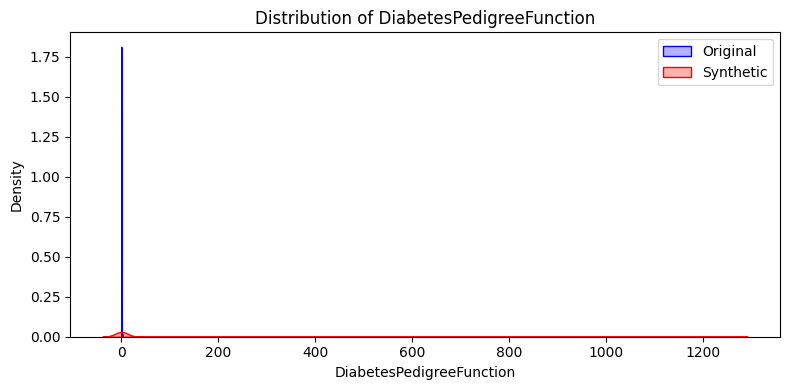

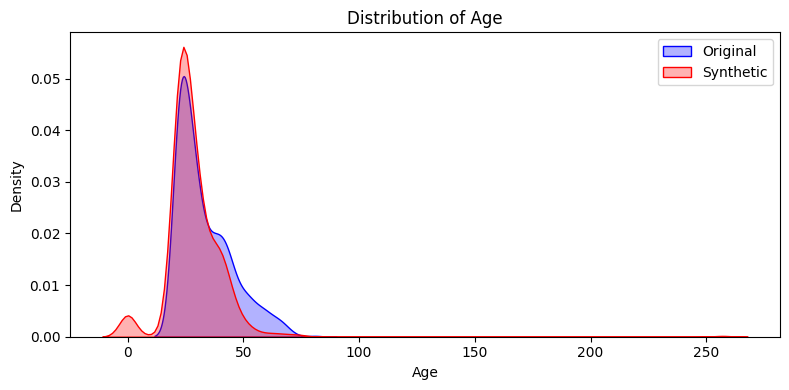

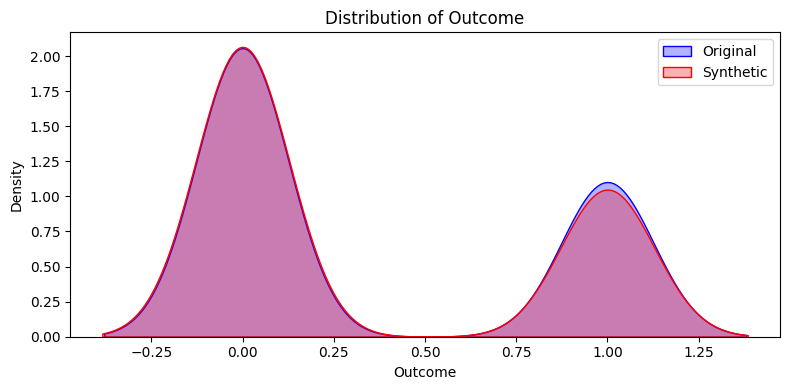

In [15]:
original_data = pd.read_csv("Real_Datasets/diabetes.csv")
synthetic_data = pd.read_csv("diabetes_syn_data/diabetes-sigma-015.csv")

plot_comparison_two_datasets(original_data, synthetic_data)